# QAQC - Unusual Large Jumps testing

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import glob

import boto3
from io import BytesIO

from IPython.display import Image

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Auxiliary functions to pre-qaqc before unusual_large_jumps functions

This functions are included in the actual qaqc libraries. I defined them here to be able to test without running full QAQC

In [2]:
#---------------------------------------------------------------------------------------------------
def qaqc_world_record(df, verbose=True):
    '''
    Checks if temperature, dewpoint, windspeed, or sea level pressure are outside North American world records
    If outside minimum or maximum records, flags values
    '''
    try:
        # world records from HadISD protocol, cross-checked with WMO database
        # https://wmo.asu.edu/content/world-meteorological-organization-global-weather-climate-extremes-archive
        T_X = {"North_America":329.92} #K
        T_N = {"North_America":210.15} #K
        D_X = {"North_America":329.85} #K
        D_N = {"North_America":173.15} #K
        W_X = {"North_America":113.2} #m/s
        W_N = {"North_America":0.} #m/s
        S_X = {"North_America":108330} #Pa
        S_N = {"North_America":87000} #Pa

        maxes = {"tas": T_X, "tdps": D_X, "tdps_derived": D_X, "sfcWind": W_X, "psl": S_X, "ps": S_X}
        mins =  {"tas": T_N, "tdps": D_N, "tdps_derived": D_N, "sfcWind": W_N, "psl": S_N, "ps": S_X}

        # variable names to check against world record limits
        wr_vars = ['tas', 'tdps_derived', 'tdps', 'sfcWind', 'psl', 'ps']

        for var in wr_vars:
            if var in list(df.columns):
                isOffRecord = np.logical_or(df[var] < mins[var]['North_America'],
                                            df[var] > maxes[var]['North_America'])
                if isOffRecord.any():
                    df.loc[isOffRecord, var + '_eraqc'] = 11
        return df
    except Exception as e:
        if verbose:
            print("qaqc_world_record failed with Exception: {}".format(e))
        return None
    
#---------------------------------------------------------------------------------------------------
def xarray_to_pandas_qaqc(ds):
    """
    """

    ## Add qc_flag variable for all variables, including elevation; 
    ## defaulting to nan for fill value that will be replaced with qc flag
    exclude_qaqc = ["time", "station", "lat", "lon", 
                    "qaqc_process", "sfcWind_method"] # lat and lon have a different qc check

    raw_qc_vars = [] # qc_variable for each data variable, will vary station to station
    era_qc_vars = [] # our qc variable
    for var in ds.data_vars:
        if 'q_code' in var:
            raw_qc_vars.append(var) # raw qc variable, need to keep for comparison, then drop
        if '_qc' in var:
            raw_qc_vars.append(var) # raw qc variables, need to keep for comparison, then drop

    for var in ds.data_vars:
        if var not in exclude_qaqc and var not in raw_qc_vars:
            qc_var = var + "_eraqc" # variable/column label
            era_qc_vars.append(qc_var)
            # adds new variable in shape of original variable with designated nan fill value
            ds = ds.assign({qc_var: xr.ones_like(ds[var])*np.nan})

    # Save attributes to inheret them to the QAQC'ed file
    attrs = ds.attrs
    var_attrs = {var:ds[var].attrs for var in list(ds.data_vars.keys())}

    df = ds.to_dataframe()
    df['anemometer_height_m'] = np.ones(ds['time'].shape)*ds.anemometer_height_m
    df['thermometer_height_m'] = np.ones(ds['time'].shape)*ds.thermometer_height_m
    
    return df

## Unusual large jumps functions

These are the new functions to test

In [3]:
#---------------------------------------------------------------------------------------------------
# Plot helper from Victoria's gap check notebook
def _plot_format_helper(var):
    """Helper function for plots"""

    pr_vars = ['pr', 'pr_5min', 'pr_1h', 'pr_24h', 'pr_localmid']
    ps_vars = ['ps', 'psl', 'psl_altimeter']
    
    if var == 'tas':
        ylab = 'Air Temperature at 2m'
        unit = 'K'
        
    elif var == 'tdps' or var == 'tdps_derived':
        ylab = 'Dewpoint Temperature'
        unit = 'K'
        
    elif var == 'sfcWind':
        ylab = 'Surface Wind Speed'
        unit = '${m s^-1}$'
        
    elif var == 'sfcWind_dir':
        ylab = 'Surface Wind Direction'
        unit = 'degrees'
        
    elif var == 'rsds':
        ylab = 'Surface Radiation'
        unit = '${W m^-2}$'
        
    elif var == 'hurs':
        ylab = 'Humidity'
        unit = '%'
        
    elif var in pr_vars:
        ylab = 'Precipitation' # should be which precip var it is
        unit = 'mm'

    elif var in ps_vars:
        ylab = 'Pressure' # should eventually be what pressure var it is
        unit = 'Pa'
        
    T_X = {"North_America":329.92} #K
    T_N = {"North_America":210.15} #K
    D_X = {"North_America":329.85} #K
    D_N = {"North_America":173.15} #K
    W_X = {"North_America":113.2} #m/s
    W_N = {"North_America":0.} #m/s
    S_X = {"North_America":108330} #Pa
    S_N = {"North_America":87000} #Pa

    maxes = {"tas": T_X, "tdps": D_X, "tdps_derived": D_X, "sfcWind": W_X, "psl": S_X, "ps": S_X}
    mins =  {"tas": T_N, "tdps": D_N, "tdps_derived": D_N, "sfcWind": W_N, "psl": S_N, "ps": S_N}

    return (ylab, unit, mins[var]['North_America'], maxes[var]['North_America'])

In [4]:
#---------------------------------------------------------------------------------------------------
def unusual_jumps_plot(df, var, flagval=22, dpi=None):
    """
    """
    
    # grab flagged data
    flag_vals = df.loc[df[var + '_eraqc'] == flagval]   
    
    # Create figure
    fig,ax = plt.subplots(figsize=(10,3))

    # Plot variable and flagged data
    df[var].plot(ax=ax, marker=".", ms=4, lw=1, color="k", alpha=0.5, label="Original data")
    
    flag_label = "{:.4f}% of data flagged".format(100*len(df.loc[df[var+"_eraqc"]==22, var])/len(df))
    df.loc[df[var+"_eraqc"]==22, var].plot(ax=ax, marker="o", ms=7, lw=0, mfc="none", color="C3", label=flag_label)    
    
    legend = ax.legend(loc=0, prop={'size': 8})    
        
    station = df['station'].unique()[0]
    network = station.split('_')[0]
    
    # Plot aesthetics
    ylab, units, miny, maxy = _plot_format_helper(var)
    ylab = '{} [{}]'.format(ylab, units)
    
    ax.set_ylabel(ylab)
    ax.set_xlabel('')
    
    # We can set ylim since this function is supposed to be run after other QAQC functions (including world records)
    miny = max(miny, df[var].min())
    maxy = min(maxy, df[var].max())
    ax.set_ylim(miny,maxy)
    
    title = 'Unusual large jumps check: {0}'.format(station)
    ax.set_title(title, fontsize=10)
    
    # save to AWS
    bucket_name = 'wecc-historical-wx'
    directory = '3_qaqc_wx'
    figname = 'qaqc_figs/qaqc_unusual_large_jumps_{0}_{1}'.format(station, var)
    key = '{0}/{1}/{2}.png'.format(directory, network, figname)
    img_data = BytesIO()
    fig.savefig(img_data, format='png', dpi=dpi, bbox_inches="tight")
    fig.savefig(figname+".png", format='png', dpi=dpi, bbox_inches="tight")
    img_data.seek(0)
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)
    bucket.put_object(Body=img_data, ContentType='image/png', Key=key)
    plt.close()
    
    return 

In [5]:
#---------------------------------------------------------------------------------------------------
def potential_spike_check(potential_spike, diff, crit, hours_diff):
    """
    data is `potential_spike`
    """

    potential_spike = potential_spike.copy(deep=True)
    
    ind = np.where(potential_spike)[0]
    spikes = pd.Series(np.zeros_like(potential_spike).astype("bool"), index=potential_spike.index)
    dates = pd.Series(potential_spike.index.values)
    # print(len(ind))
    # print(dates[ind])
    
    for i in ind:
        
        #Ignore edges for now
        if i==1 or i>=len(potential_spike)-4:
            continue
        # Indices, critical values, and values before and after potential spike
        im1, i0, ip1, ip2, ip3, ip4 = [i-1, i, i+1, i+2, i+3, i+4]
        tm1, t0, tp1, tp2, tp3, tp4 = diff.iloc[[im1, i0, ip1, ip2, ip3, ip4]]
        cm1, c0, cp1, cp2, cp3, cp4 = crit.iloc[[im1, i0, ip1, ip2, ip3, ip4]]
        # print(dates.iloc[[i0,ip1]])
        # print(" sgn(t0)[{}] != sgn(tm1)[{}] \n abs(tm1)[{}] < cm1[{}] \n abs(tp1)[{}] > cp1[{}] \n abs(tp2)[{}] < cp2[{}]".format(np.sign(t0),np.sign(tp1), np.abs(tm1), cm1, np.abs(tp1), cp1, np.abs(tp2), cp2))
        # print()
        # Three-values spike
        if (
            np.sign(t0) != np.sign(tp2) and 
            np.abs(tm1) < 0.5*cm1 and 
            np.abs(tp1) < 0.5*cp1 and 
            np.abs(tp2) < 0.5*cp2 and 
            np.abs(tp3) > cp3 and 
            np.abs(tp4) < 0.5*cp4
        ):
            # print(dates.iloc[i0])
            spikes.iloc[[i0,ip1,ip2]] = True
            # i += 3
            # continue
            
        # Two-values spike
        elif (
            np.sign(t0) != np.sign(tp2) and 
            np.abs(tm1) < 0.5*cm1 and 
            np.abs(tp1) < 0.5*cp1 and 
            np.abs(tp2) > cp2 and 
            np.abs(tp3) < 0.5*cp3
        ):
            # print(dates.iloc[i0])
            spikes.iloc[[i0,ip1]] = True
            # i += 2
            # continue
        
        # One-value spike
        elif( 
            np.sign(t0) != np.sign(tp1) and 
            np.abs(tm1) < 1.0*cm1 and 
            np.abs(tp1) > cp1 and 
            np.abs(tp2) < 1.0*cp2
        ):
            # print(dates.iloc[i0])
            spikes.iloc[i0] = True
            # i += 1
            # continue
        
    return spikes

In [6]:
#---------------------------------------------------------------------------------------------------
def detect_spikes(df, var, iqr_thresh=6, min_datapoints=50):
    """
    
    """
    
    df = df.copy(deep=True)
    
    # Calculate difference in var values
    df[var+'_difference'] = df[var].diff().fillna(0)
    
    # Calculate dates
    df['date'] = df.index.values
    
    # Calculate time difference
    df['time_diff'] = df['date'].diff().fillna(pd.Timedelta(0))
    
    # Calculate time differece in hours
    df['hours_diff'] = df['time_diff']/np.timedelta64(1, 'h')
    df = df[np.logical_and(df['hours_diff'] > 0, df['hours_diff'] <= 12)]
    
    # Group by month to avoid strong seasonal cycle
    # grouped = df.groupby([pd.Grouper(freq='M'), df['hours_diff']]) 
    grouped = df.groupby(pd.Grouper(freq='M')) 

    # Count number of data per month
    counts = grouped[var+'_difference'].transform("count")
    df[var+'_counts'] = counts
    # Keep only months with more than 50 values to be statistically valid
    df = df[df[var+'_counts']>min_datapoints]

    # Define modified IQR 
    # kwargs = {'rng':(20, 80),}
    kwargs = {}
    
    # Calculate iqr
    iqr = grouped[var+'_difference'].transform(scipy.stats.iqr, **kwargs)
    df[var+'_iqr'] = iqr

    # Calculate critical value as rounded-up 6 (or defined by argument) times IQR
    df[var+'_critical'] = np.ceil(iqr_thresh*df[var+'_iqr'])
    
    # Find potential spike values where var diff is higher than the critical value
    df[var+'_potential_spikes'] = np.abs(df[var+'_difference'])>df[var+'_critical']

    # Filter real spikes using `potential_spike_check` function
    spikes = potential_spike_check(df[var+'_potential_spikes'], df[var+'_difference'], df[var+'_critical'], df['hours_diff'])
    df[var+'_spikes'] = spikes
    
    return df

In [7]:
#---------------------------------------------------------------------------------------------------
def unusual_large_jumps(df, iqr_thresh=6, min_datapoints=50, plot=True):
    """
    Test for unusual large jumps or ''spikes'', given the statistics of the series. Analysis for each individual month in 
    time series to account for seasonal cycles in different regions.
    
    This test is done for ["tas", "tdps", "ps", "slp"]
    Should it be done for more vars?
    
    Input:
    -----
            df [pandas dataframe] : station dataset converted to dataframe through QAQC pipeline
            iqr_thresh [int] : critical value (iqr_thresh*IQR) for spike detection (default=6)
            min_datapoints [int] : minimum data points in each month to be valid for testing (default=50)
            plot [bool] : if True, produces plot and uploads it to AWS
    Output:
    ------
            if qaqc succeded:
                 df [pandas dataframe] : QAQC dataframe with flagged values (see below for flag meaning).
            else if qaqc failed:
                 None
    Flag meaninig:
    -------------
        22,qaqc_unusual_large_jumps,Unusual jump (spike) in variable
    """
    
    # Save original df multiindex and create station column
    MultiIndex = df.index
    df['station'] = df.index.get_level_values(0)
    
    # Drop station index
    df = df.droplevel(level="station")
    
    # Define test variables and check if they are in the dataframe
    check_vars = ["tas", "tdps", "tdps_derived", "ps", "slp"]
    variables = [var for var in check_vars if var in df.columns]
    
    # Loop through test variables
    for var in variables:
        # Create a copy of the original dataframe and drop NaNs in the testing variable
        new_df = df.copy(deep=True)
        new_df = new_df.dropna(subset=var)#.drop(columns=["lat","lon","elevation"])
        # Use only values that have not been flagged by previous QAQC tests
        valid = np.where(np.isnan(new_df[var+"_eraqc"]))[0]
        new_df = new_df.iloc[valid]
        # Detect spikes
        new_df = detect_spikes(new_df, var=var, iqr_thresh=iqr_thresh, min_datapoints=min_datapoints)
        # Retrieve location of spikes
        ind = new_df.index[np.where(new_df[var+"_spikes"])[0]]
        # Flag _eraqc variable
        df.loc[ind, var+"_eraqc"] = 22
    
        if plot:
            unusual_jumps_plot(df, var, flagval=22)
    
    # Reassign original MultiIndex
    df.set_index(MultiIndex, inplace=True)
    
    return df

In [8]:
ds = xr.open_dataset('train_files/SNOTEL_835.nc')

In [9]:
df = xarray_to_pandas_qaqc(ds)
df.head(5)

tas      pr tas_qc pr_qc  elevation  \
station    time                                                              
SNOTEL_835 1980-01-01 08:00:00         NaN  317.50    nan     E    1706.88   
           1980-01-02 08:00:00         NaN  317.50    nan     E    1706.88   
           1980-01-03 08:00:00         NaN  317.50    nan     E    1706.88   
           1980-01-04 08:00:00         NaN  320.04    nan     E    1706.88   
           1980-01-04 12:00:00  258.761111  320.04      V     E    1706.88   

                                     lat        lon  tas_eraqc  pr_eraqc  \
station    time                                                            
SNOTEL_835 1980-01-01 08:00:00  46.14287 -114.44755        NaN       NaN   
           1980-01-02 08:00:00  46.14287 -114.44755        NaN       NaN   
           1980-01-03 08:00:00  46.14287 -114.44755        NaN       NaN   
           1980-01-04 08:00:00  46.14287 -114.44755        NaN       NaN   
           1980-01-04 12:00:00  46.14287 -114.44755        NaN       NaN   

                                elevation_eraqc  anemometer_height_m  \
station    time                                                        
SNOTEL_835 1980-01-01 08:00:00              NaN                  1.5   
           1980-01-02 08:00:00              NaN                  1.5   
           1980-01-03 08:00:00              NaN                  1.5   
           1980-01-04 08:00:00              NaN                  1.5   
           1980-01-04 12:00:00              NaN                  1.5   

                                thermometer_height_m  
station    time                                       
SNOTEL_835 1980-01-01 08:00:00                   NaN  
           1980-01-02 08:00:00                   NaN  
           1980-01-03 08:00:00                   NaN  
           1980-01-04 08:00:00                   NaN  
           1980-01-04 12:00:00                   NaN

In [10]:
new_df = qaqc_world_record(df)
print(np.where(~np.isnan(new_df.tas_eraqc))[0])
df.head(5)

[]


tas      pr tas_qc pr_qc  elevation  \
station    time                                                              
SNOTEL_835 1980-01-01 08:00:00         NaN  317.50    nan     E    1706.88   
           1980-01-02 08:00:00         NaN  317.50    nan     E    1706.88   
           1980-01-03 08:00:00         NaN  317.50    nan     E    1706.88   
           1980-01-04 08:00:00         NaN  320.04    nan     E    1706.88   
           1980-01-04 12:00:00  258.761111  320.04      V     E    1706.88   

                                     lat        lon  tas_eraqc  pr_eraqc  \
station    time                                                            
SNOTEL_835 1980-01-01 08:00:00  46.14287 -114.44755        NaN       NaN   
           1980-01-02 08:00:00  46.14287 -114.44755        NaN       NaN   
           1980-01-03 08:00:00  46.14287 -114.44755        NaN       NaN   
           1980-01-04 08:00:00  46.14287 -114.44755        NaN       NaN   
           1980-01-04 12:00:00  46.14287 -114.44755        NaN       NaN   

                                elevation_eraqc  anemometer_height_m  \
station    time                                                        
SNOTEL_835 1980-01-01 08:00:00              NaN                  1.5   
           1980-01-02 08:00:00              NaN                  1.5   
           1980-01-03 08:00:00              NaN                  1.5   
           1980-01-04 08:00:00              NaN                  1.5   
           1980-01-04 12:00:00              NaN                  1.5   

                                thermometer_height_m  
station    time                                       
SNOTEL_835 1980-01-01 08:00:00                   NaN  
           1980-01-02 08:00:00                   NaN  
           1980-01-03 08:00:00                   NaN  
           1980-01-04 08:00:00                   NaN  
           1980-01-04 12:00:00                   NaN

In [11]:
new_df = unusual_large_jumps(new_df)
print(np.where(~np.isnan(new_df.tas_eraqc))[0])
new_df.head()

[ 12202  12203  17333  19372  21418  26064  39844  55988  55989  74987
 122887]


tas      pr tas_qc pr_qc  elevation  \
station    time                                                              
SNOTEL_835 1980-01-01 08:00:00         NaN  317.50    nan     E    1706.88   
           1980-01-02 08:00:00         NaN  317.50    nan     E    1706.88   
           1980-01-03 08:00:00         NaN  317.50    nan     E    1706.88   
           1980-01-04 08:00:00         NaN  320.04    nan     E    1706.88   
           1980-01-04 12:00:00  258.761111  320.04      V     E    1706.88   

                                     lat        lon  tas_eraqc  pr_eraqc  \
station    time                                                            
SNOTEL_835 1980-01-01 08:00:00  46.14287 -114.44755        NaN       NaN   
           1980-01-02 08:00:00  46.14287 -114.44755        NaN       NaN   
           1980-01-03 08:00:00  46.14287 -114.44755        NaN       NaN   
           1980-01-04 08:00:00  46.14287 -114.44755        NaN       NaN   
           1980-01-04 12:00:00  46.14287 -114.44755        NaN       NaN   

                                elevation_eraqc  anemometer_height_m  \
station    time                                                        
SNOTEL_835 1980-01-01 08:00:00              NaN                  1.5   
           1980-01-02 08:00:00              NaN                  1.5   
           1980-01-03 08:00:00              NaN                  1.5   
           1980-01-04 08:00:00              NaN                  1.5   
           1980-01-04 12:00:00              NaN                  1.5   

                                thermometer_height_m     station  
station    time                                                   
SNOTEL_835 1980-01-01 08:00:00                   NaN  SNOTEL_835  
           1980-01-02 08:00:00                   NaN  SNOTEL_835  
           1980-01-03 08:00:00                   NaN  SNOTEL_835  
           1980-01-04 08:00:00                   NaN  SNOTEL_835  
           1980-01-04 12:00:00                   NaN  SNOTEL_835

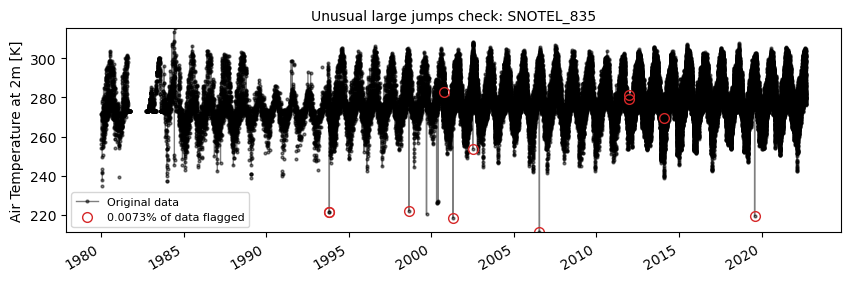

In [12]:
figures = glob.glob("qaqc_figs/qaqc_unusual_large_jumps_{}_*.png".format(new_df.index[0][0]))
for fig in figures:
    display(Image(filename=fig) )

## Testing

In [13]:
check_vars = ["tas", "tdps", "tdps_derived", "ps", "slp"]

In [14]:
files = np.sort(glob.glob("train_files/*.nc"))
networks = np.unique([n.split("/")[-1].split("_")[0] for n in files])
print(networks)

['ASOSAWOS' 'CAHYDRO' 'CDEC' 'CIMIS' 'CNRFC' 'CRN' 'CW3E' 'CWOP' 'HADS'
 'HOLFUY' 'LOXWFO' 'MAP' 'NCAWOS' 'NDBC' 'NOS-NWLON' 'OtherISD' 'RAWS'
 'SCAN' 'SNOTEL']


### ASOSAWOS

['tas', 'tdps', 'ps']


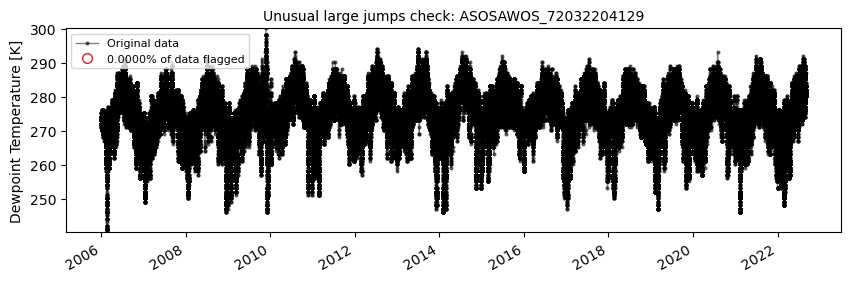

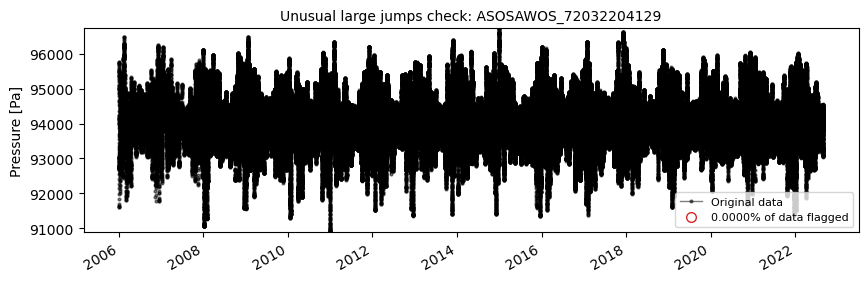

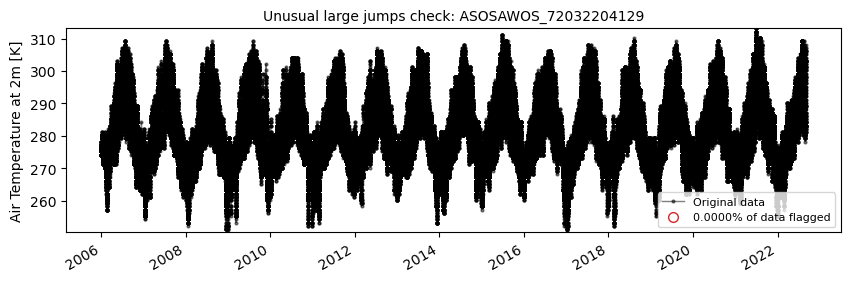

In [15]:
ds = xr.open_dataset('train_files/ASOSAWOS_72032204129.nc')
df = xarray_to_pandas_qaqc(ds)
variables = [var for var in check_vars if var in df.columns]
print(variables)
new_df = qaqc_world_record(df)
new_df = unusual_large_jumps(new_df)

figures = glob.glob("qaqc_figs/qaqc_unusual_large_jumps_{}_*.png".format(new_df.index[0][0]))
for fig in figures:
    display(Image(filename=fig) )

### CAHYDRO

['tas', 'tdps_derived']


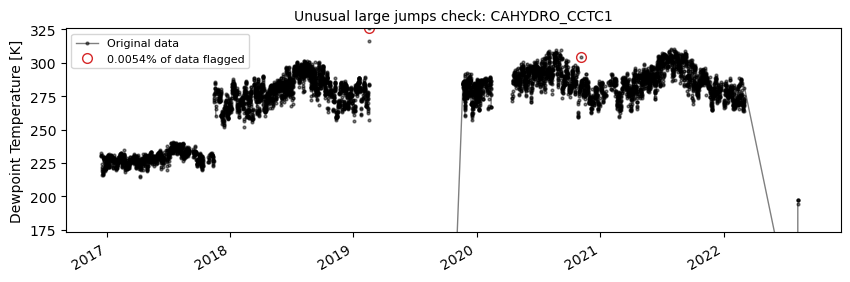

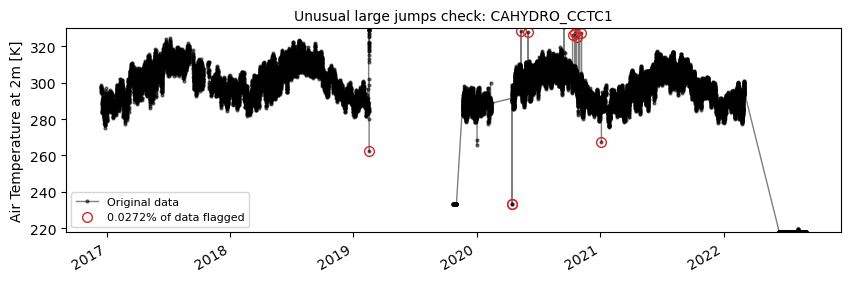

In [16]:
ds = xr.open_dataset('train_files/CAHYDRO_CCTC1.nc')
df = xarray_to_pandas_qaqc(ds)
variables = [var for var in check_vars if var in df.columns]
print(variables)
new_df = qaqc_world_record(df)
new_df = unusual_large_jumps(new_df)

figures = glob.glob("qaqc_figs/qaqc_unusual_large_jumps_{}_*.png".format(new_df.index[0][0]))
for fig in figures:
    display(Image(filename=fig) )

['tas']


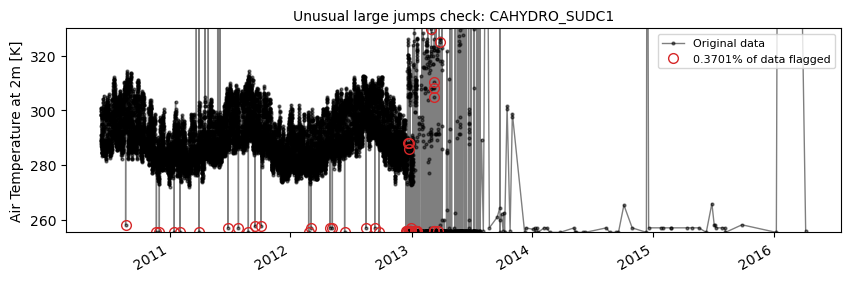

In [17]:
ds = xr.open_dataset('train_files/CAHYDRO_SUDC1.nc')
df = xarray_to_pandas_qaqc(ds)
variables = [var for var in check_vars if var in df.columns]
print(variables)
new_df = qaqc_world_record(df)
new_df = unusual_large_jumps(new_df)

figures = glob.glob("qaqc_figs/qaqc_unusual_large_jumps_{}_*.png".format(new_df.index[0][0]))
for fig in figures:
    display(Image(filename=fig) )

### CDEC

['tas', 'tdps_derived', 'ps']


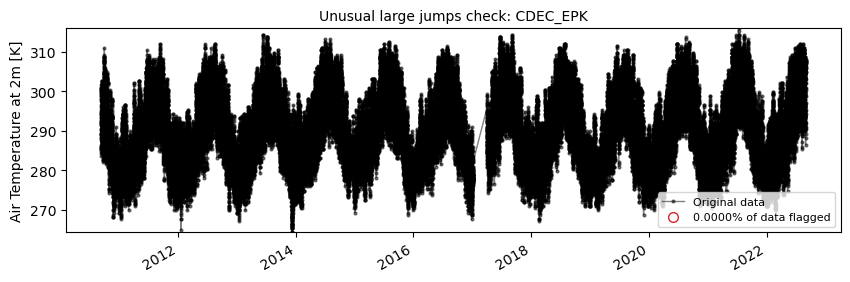

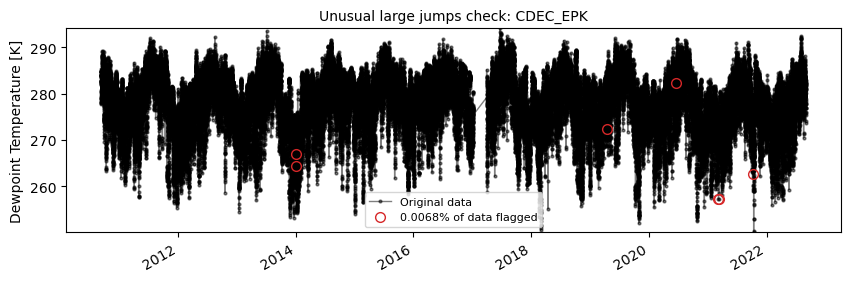

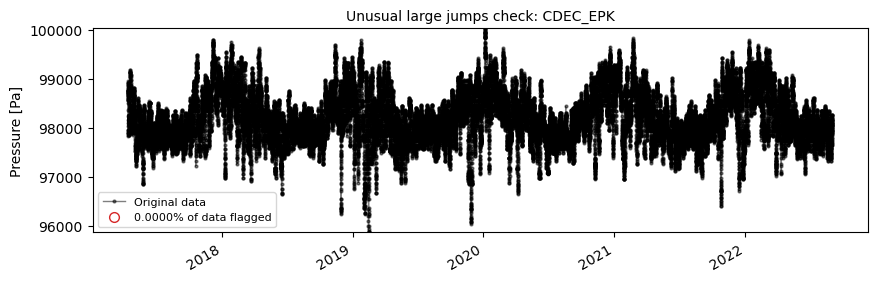

In [18]:
ds = xr.open_dataset('train_files/CDEC_EPK.nc')
df = xarray_to_pandas_qaqc(ds)
variables = [var for var in check_vars if var in df.columns]
print(variables)
new_df = qaqc_world_record(df)
new_df = unusual_large_jumps(new_df)

figures = glob.glob("qaqc_figs/qaqc_unusual_large_jumps_{}_*.png".format(new_df.index[0][0]))
for fig in figures:
    display(Image(filename=fig) )

### CIMIS

['tas', 'tdps_derived']


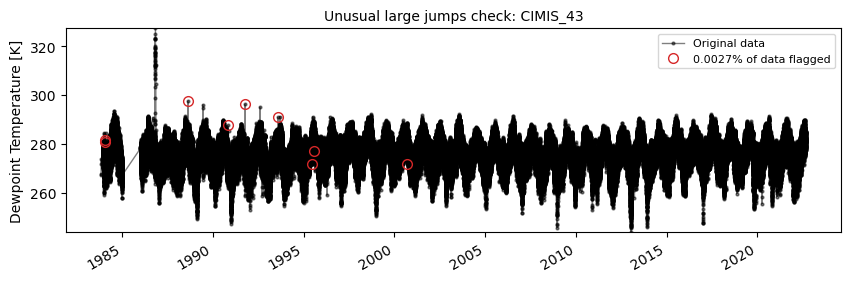

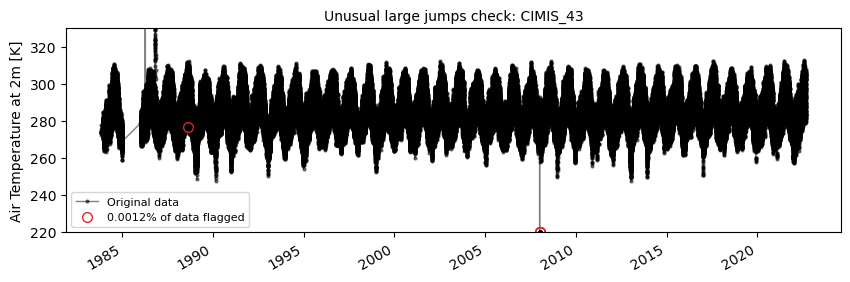

In [19]:
ds = xr.open_dataset('train_files/CIMIS_43.nc')
df = xarray_to_pandas_qaqc(ds)
variables = [var for var in check_vars if var in df.columns]
print(variables)
new_df = qaqc_world_record(df)
new_df = unusual_large_jumps(new_df)

figures = glob.glob("qaqc_figs/qaqc_unusual_large_jumps_{}_*.png".format(new_df.index[0][0]))
for fig in figures:
    display(Image(filename=fig) )

### CNRFC

In [20]:
ds = xr.open_dataset('train_files/CNRFC_DGDC1.nc')
df = xarray_to_pandas_qaqc(ds)
variables = [var for var in check_vars if var in df.columns]
print(variables)
new_df = qaqc_world_record(df)
new_df = unusual_large_jumps(new_df)

figures = glob.glob("qaqc_figs/qaqc_unusual_large_jumps_{}_*.png".format(new_df.index[0][0]))
for fig in figures:
    display(Image(filename=fig))

[]


### CRN

['tas']


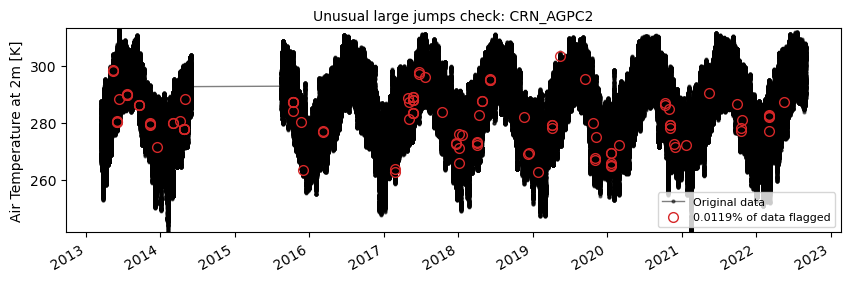

In [21]:
ds = xr.open_dataset('train_files/CRN_AGPC2.nc')
df = xarray_to_pandas_qaqc(ds)
variables = [var for var in check_vars if var in df.columns]
print(variables)
new_df = qaqc_world_record(df)
new_df = unusual_large_jumps(new_df)

figures = glob.glob("qaqc_figs/qaqc_unusual_large_jumps_{}_*.png".format(new_df.index[0][0]))
for fig in figures:
    display(Image(filename=fig) )

### CWOP

['tas', 'tdps_derived']


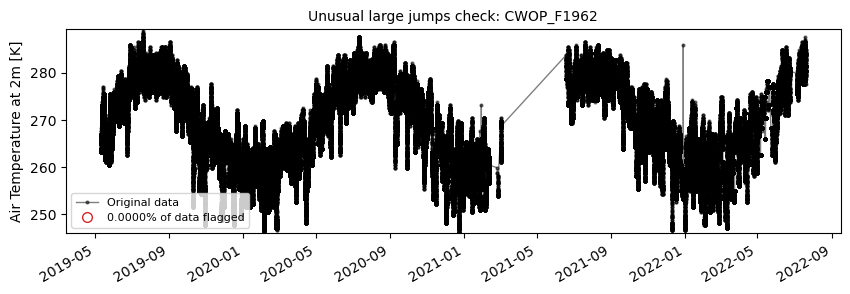

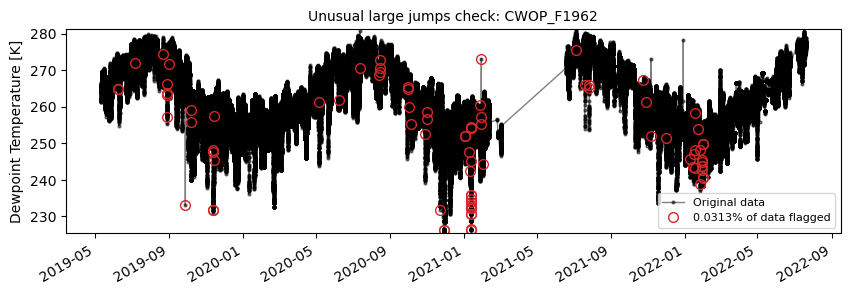

In [22]:
ds = xr.open_dataset('train_files/CWOP_F1962.nc')
df = xarray_to_pandas_qaqc(ds)
variables = [var for var in check_vars if var in df.columns]
print(variables)
new_df = qaqc_world_record(df)
new_df = unusual_large_jumps(new_df)

figures = glob.glob("qaqc_figs/qaqc_unusual_large_jumps_{}_*.png".format(new_df.index[0][0]))
for fig in figures:
    display(Image(filename=fig) )

### HADS

['tas']


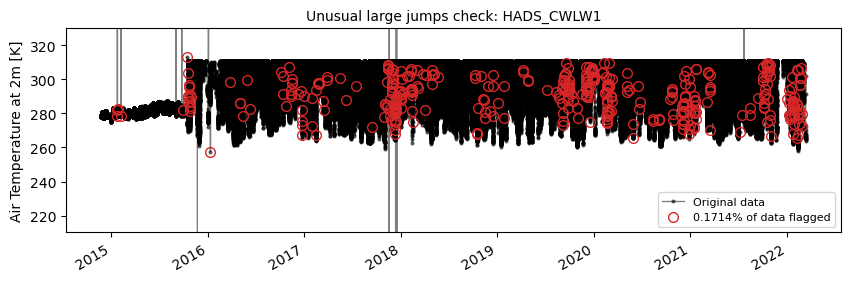

In [23]:
ds = xr.open_dataset('train_files/HADS_CWLW1.nc')
df = xarray_to_pandas_qaqc(ds)
variables = [var for var in check_vars if var in df.columns]
print(variables)
new_df = qaqc_world_record(df)
new_df = unusual_large_jumps(new_df)

figures = glob.glob("qaqc_figs/qaqc_unusual_large_jumps_{}_*.png".format(new_df.index[0][0]))
for fig in figures:
    display(Image(filename=fig) )

### HOLFUY

['tas', 'tdps_derived']


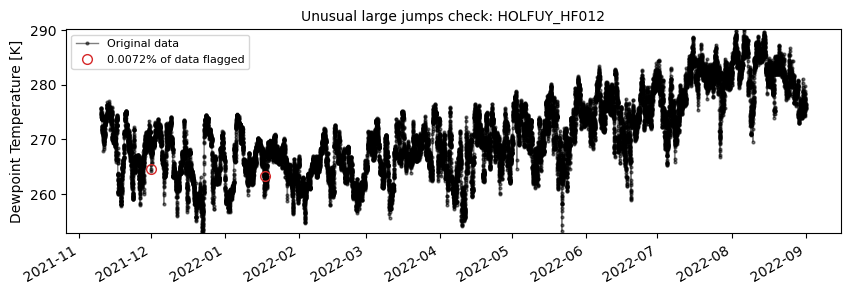

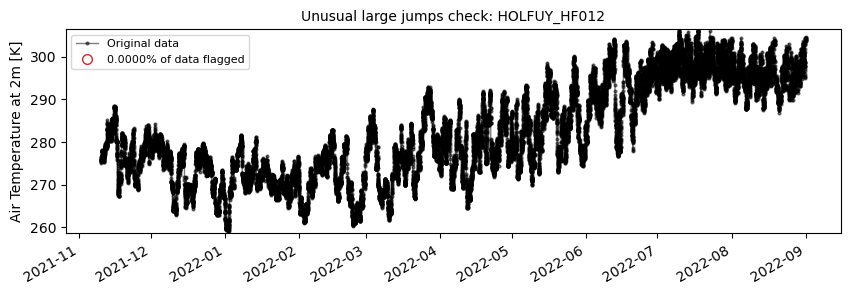

In [24]:
ds = xr.open_dataset('train_files/HOLFUY_HF012.nc')
df = xarray_to_pandas_qaqc(ds)
variables = [var for var in check_vars if var in df.columns]
print(variables)
new_df = qaqc_world_record(df)
new_df = unusual_large_jumps(new_df)

figures = glob.glob("qaqc_figs/qaqc_unusual_large_jumps_{}_*.png".format(new_df.index[0][0]))
for fig in figures:
    display(Image(filename=fig) )

### LOXWFO

['tas', 'tdps_derived']


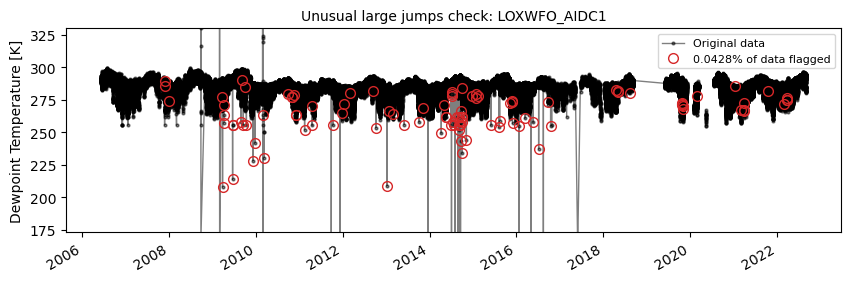

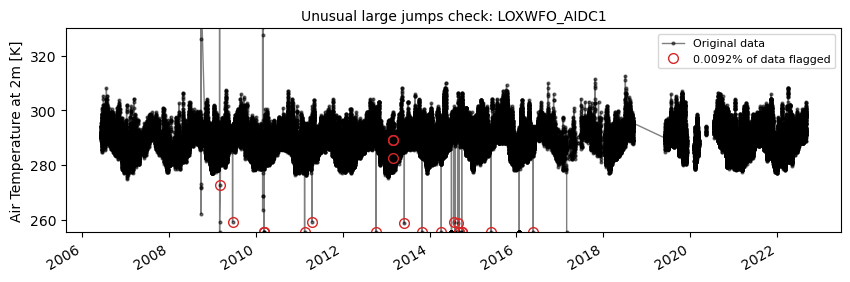

In [25]:
ds = xr.open_dataset('train_files/LOXWFO_AIDC1.nc')
df = xarray_to_pandas_qaqc(ds)
variables = [var for var in check_vars if var in df.columns]
print(variables)
new_df = qaqc_world_record(df)
new_df = unusual_large_jumps(new_df)

figures = glob.glob("qaqc_figs/qaqc_unusual_large_jumps_{}_*.png".format(new_df.index[0][0]))
for fig in figures:
    display(Image(filename=fig) )

### MAP

['tas', 'tdps_derived']


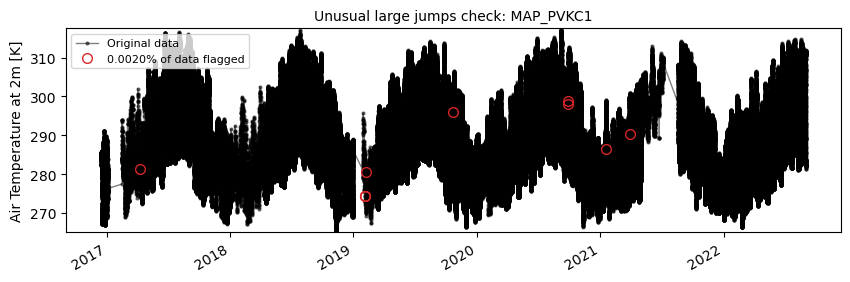

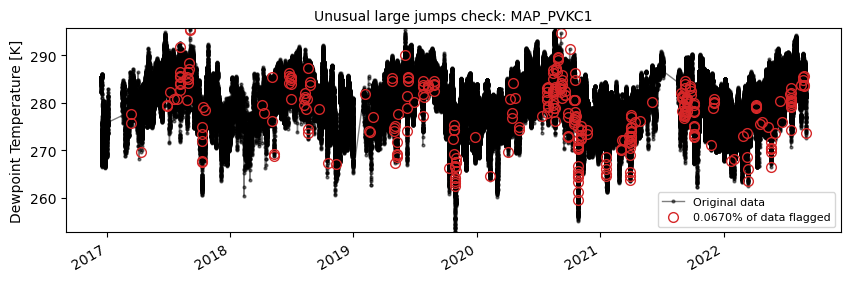

In [26]:
ds = xr.open_dataset('train_files/MAP_PVKC1.nc')
df = xarray_to_pandas_qaqc(ds)
variables = [var for var in check_vars if var in df.columns]
print(variables)
new_df = qaqc_world_record(df)
new_df = unusual_large_jumps(new_df)

figures = glob.glob("qaqc_figs/qaqc_unusual_large_jumps_{}_*.png".format(new_df.index[0][0]))
for fig in figures:
    display(Image(filename=fig) )

### NCAWOS

['tas', 'tdps_derived']


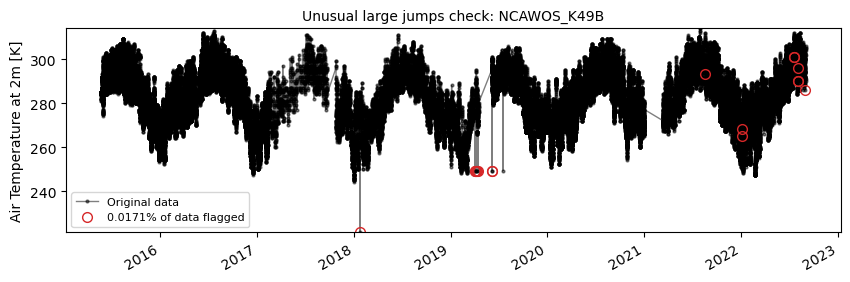

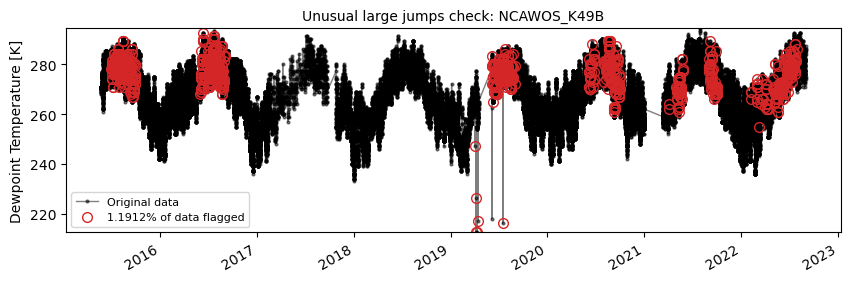

In [27]:
ds = xr.open_dataset('train_files/NCAWOS_K49B.nc')
df = xarray_to_pandas_qaqc(ds)
variables = [var for var in check_vars if var in df.columns]
print(variables)
new_df = qaqc_world_record(df)
new_df = unusual_large_jumps(new_df)

figures = glob.glob("qaqc_figs/qaqc_unusual_large_jumps_{}_*.png".format(new_df.index[0][0]))
for fig in figures:
    display(Image(filename=fig) )

### NOS-NWLON

['tas']


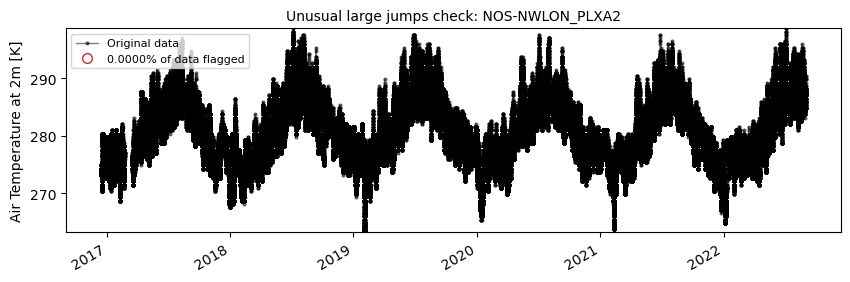

In [28]:
ds = xr.open_dataset('train_files/NOS-NWLON_PLXA2.nc')
df = xarray_to_pandas_qaqc(ds)
variables = [var for var in check_vars if var in df.columns]
print(variables)
new_df = qaqc_world_record(df)
new_df = unusual_large_jumps(new_df)

figures = glob.glob("qaqc_figs/qaqc_unusual_large_jumps_{}_*.png".format(new_df.index[0][0]))
for fig in figures:
    display(Image(filename=fig) )

### NDBC

['tas', 'tdps', 'ps']


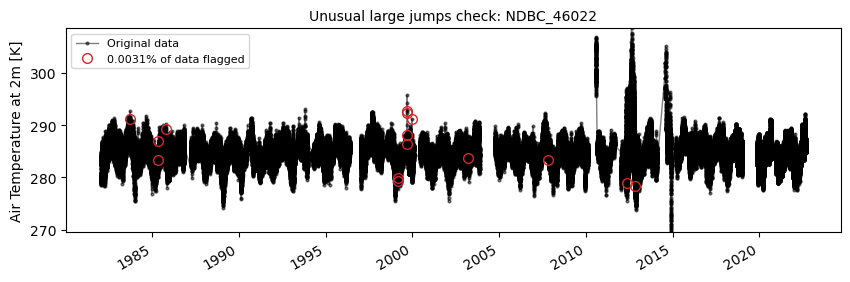

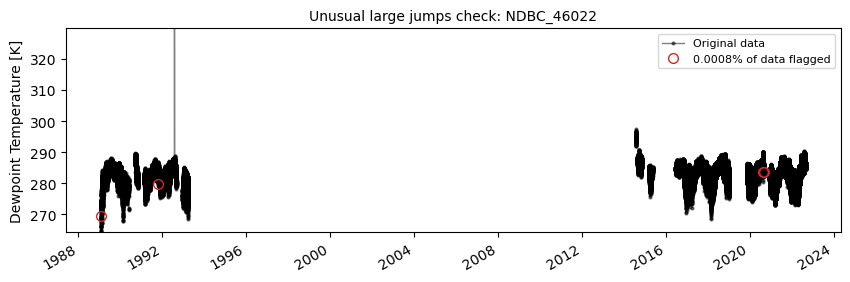

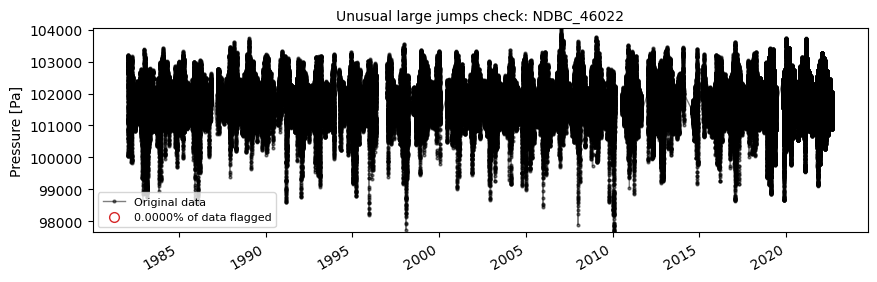

In [29]:
ds = xr.open_dataset('train_files/NDBC_46022.nc')
df = xarray_to_pandas_qaqc(ds)
variables = [var for var in check_vars if var in df.columns]
print(variables)
new_df = qaqc_world_record(df)
new_df = unusual_large_jumps(new_df)

figures = glob.glob("qaqc_figs/qaqc_unusual_large_jumps_{}_*.png".format(new_df.index[0][0]))
for fig in figures:
    display(Image(filename=fig) )

### OtherISD

/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/Users/hector/anaconda3/envs/era_py39/lib/python3.9/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


['tas', 'tdps', 'ps']


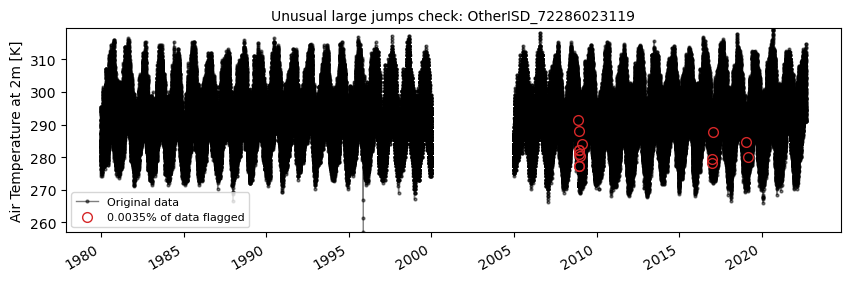

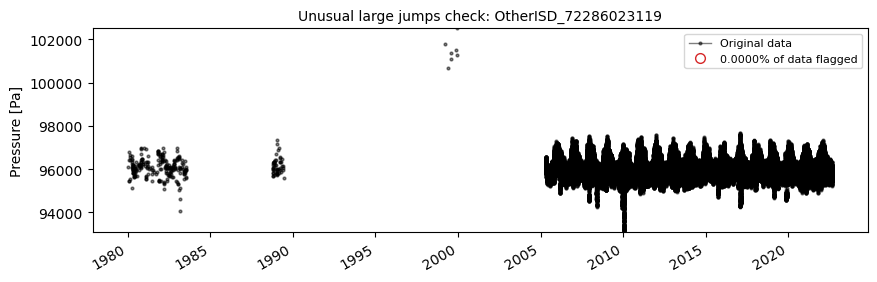

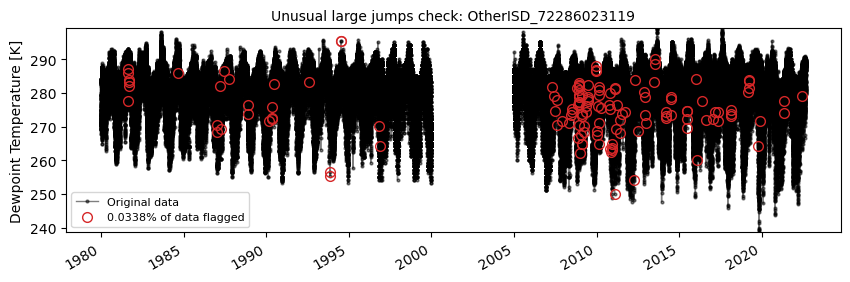

In [30]:
ds = xr.open_dataset('train_files/OtherISD_72286023119.nc')
df = xarray_to_pandas_qaqc(ds)
variables = [var for var in check_vars if var in df.columns]
print(variables)
new_df = qaqc_world_record(df)
new_df = unusual_large_jumps(new_df)

figures = glob.glob("qaqc_figs/qaqc_unusual_large_jumps_{}_*.png".format(new_df.index[0][0]))
for fig in figures:
    display(Image(filename=fig) )

### RAWS

['tas', 'tdps_derived']


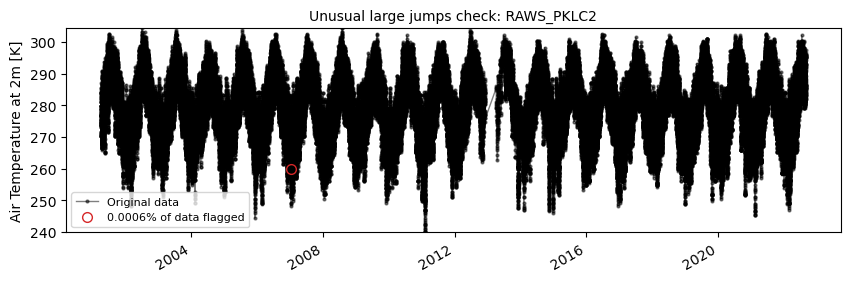

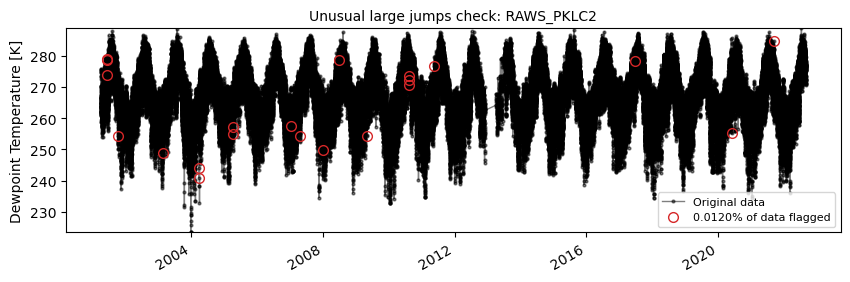

In [31]:
ds = xr.open_dataset('train_files/RAWS_PKLC2.nc')
df = xarray_to_pandas_qaqc(ds)
variables = [var for var in check_vars if var in df.columns]
print(variables)
new_df = qaqc_world_record(df)
new_df = unusual_large_jumps(new_df)

figures = glob.glob("qaqc_figs/qaqc_unusual_large_jumps_{}_*.png".format(new_df.index[0][0]))
for fig in figures:
    display(Image(filename=fig) )

### SCAN

['tas', 'tdps']


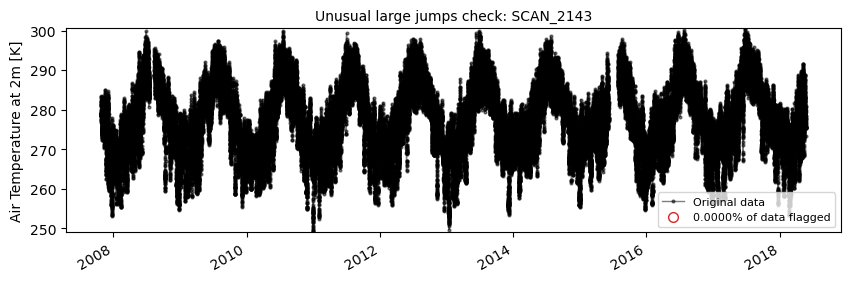

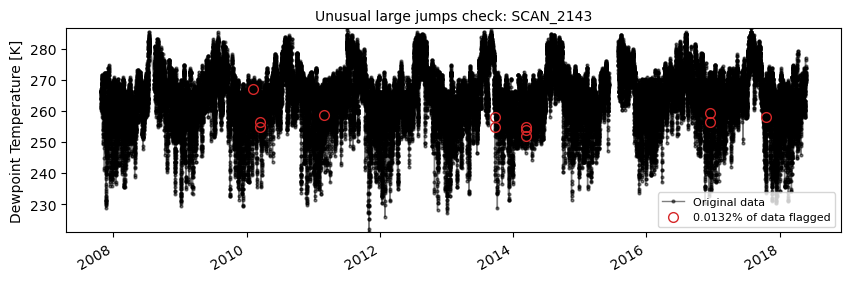

In [32]:
ds = xr.open_dataset('train_files/SCAN_2143.nc')
df = xarray_to_pandas_qaqc(ds)
variables = [var for var in check_vars if var in df.columns]
print(variables)
new_df = qaqc_world_record(df)
new_df = unusual_large_jumps(new_df)

figures = glob.glob("qaqc_figs/qaqc_unusual_large_jumps_{}_*.png".format(new_df.index[0][0]))
for fig in figures:
    display(Image(filename=fig) )

### SNOTEL

['tas']


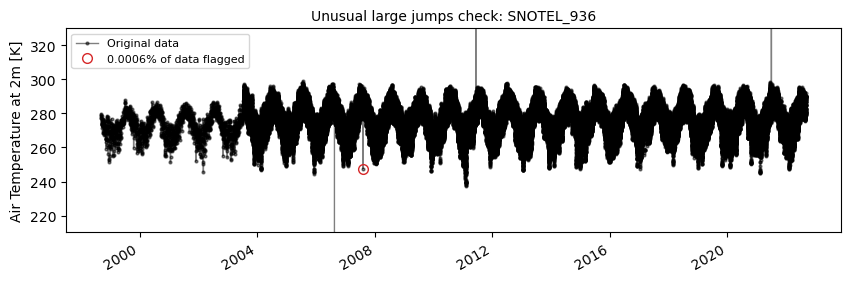

In [33]:
ds = xr.open_dataset('train_files/SNOTEL_936.nc')
df = xarray_to_pandas_qaqc(ds)
variables = [var for var in check_vars if var in df.columns]
print(variables)
new_df = qaqc_world_record(df)
new_df = unusual_large_jumps(new_df)

figures = glob.glob("qaqc_figs/qaqc_unusual_large_jumps_{}_*.png".format(new_df.index[0][0]))
for fig in figures:
    display(Image(filename=fig) )

### CW3E

In [35]:
# ds = xr.open_dataset('train_files/CW3E_BCC_21.nc')
# df = xarray_to_pandas_qaqc(ds)
# variables = [var for var in check_vars if var in df.columns]
# print(variables)
# new_df = qaqc_world_record(df)
# new_df = unusual_large_jumps(new_df)

# figures = glob.glob("qaqc_figs/qaqc_unusual_large_jumps_{}_*.png".format(new_df.index[0][0]))
# for fig in figures:
#     display(Image(filename=fig) )